Ramp rates (MW/hour): {3: array([14.99989437]), 4: array([9.99991846]), 5: array([50.00747873])}
Adjusted Ramp Rates (MW/hour): {3: array([14.99991163]), 4: array([10.00000003]), 5: array([48.28013923])}
                                     CVXPY                                     
                                     v1.6.0                                    
(CVXPY) Jan 27 02:20:05 PM: Your problem has 840 variables, 101130 constraints, and 0 parameters.
(CVXPY) Jan 27 02:20:05 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jan 27 02:20:05 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jan 27 02:20:05 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jan 27 02:20:05 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                      

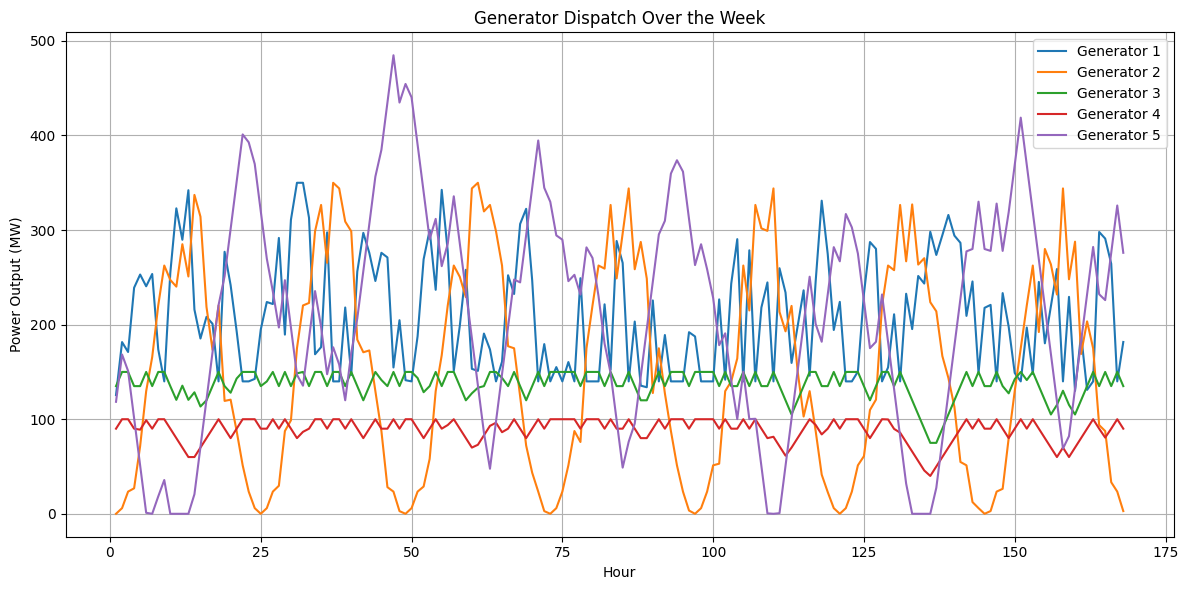

In [11]:
# GEN 1: WIND 
# GEN 2:SOLAR 
# GEN 3, 4, 5: COAL N GAS
# IMPORT LIBRARIES
import pandas as pd
import numpy as np
import cvxpy as cp
from ddeint import ddeint
import matplotlib.pyplot as plt

#print(cp.installed_solvers())

# -------------------------------------------------------------------------------------------------------
# INPUT DATA
generator_data = pd.read_csv("provided_material/generators.csv", index_col=0)
node_demands = pd.read_csv("provided_material/hourlydemandbynode.csv", index_col=0)
shift_factor_matrix = pd.read_csv("provided_material/shiftfactormatrix.csv", index_col=0)
line_ratings = pd.read_csv("provided_material/lineratings.csv", index_col=0)

# -------------------------------------------------------------------------------------------------------
# EXTRACT REQUIRED INFO FROM INPUT DATA
gen_IDs = np.array(generator_data.loc[:, "NODE"].astype(int))
gen_marginal_costs = np.array(generator_data.loc[:, "MC"])  # (£/MWh)
gen_capacities = np.array(generator_data.loc[:, "CAP"])  # (MW)

demand_IDs = np.array(node_demands.columns.astype(int))
node_IDs = np.array(shift_factor_matrix.columns.astype(int))

# -------------------------------------------------------------------------------------------------------
# FUNCTION TO SIMULATE DDE AND DETERMINE RAMP RATES
def simulate_dde(tau, delay, P_initial, P_target, duration=10, steps=1000):
    time = np.linspace(0, duration, steps)

    def model(P, t):
        return (P_target - P(t - delay)) / tau

    def history(t):
        return P_initial

    response = ddeint(model, history, time)
    ramp_rate = (response[-1] - response[0]) / duration
    
    # Normalize ramp rate by capacity
    normalized_ramp_rate = abs(ramp_rate / P_target)  # Normalize by target power
    return normalized_ramp_rate

    #return abs(ramp_rate)


# Rescale tau and delay for each generator
base_tau = 1.5
base_delay = 0.5
tau_scaling = [1, gen_capacities[3] / gen_capacities[2], gen_capacities[4] / gen_capacities[2]]
delay_scaling = [1, gen_capacities[3] / gen_capacities[2], gen_capacities[4] / gen_capacities[2]]

# New tau and delay values
tau_values = [base_tau * scale for scale in tau_scaling]
delay_values = [base_delay * scale for scale in delay_scaling]

# Calculate ramp rates
ramp_rates = {}
for gen_id, tau, delay, P_initial, P_target in zip(
    [3, 4, 5], [1.6, 1.7, 2.5], [0.55, 0.6, 1.0], [0, 0, 0], [gen_capacities[2], gen_capacities[3], gen_capacities[4]]
):
    ramp_rates[gen_id] = simulate_dde(tau, delay, P_initial, P_target) * P_target 
print("Ramp rates (MW/hour):", ramp_rates)

new_ramp_rates = {}
for gen_id, tau, delay, P_initial, P_target in zip(
    [3, 4, 5], tau_values, delay_values, [0, 0, 0], [gen_capacities[2], gen_capacities[3], gen_capacities[4]]
):
    new_ramp_rates[gen_id] = simulate_dde(tau, delay, P_initial, P_target) * P_target  # Scale to MW/hour
print("Adjusted Ramp Rates (MW/hour):", new_ramp_rates)

# -------------------------------------------------------------------------------------------------------
# GENERATOR AND DEMAND MATRICES
gen_indices = {g_ID: np.where(node_IDs == g_ID)[0][0] for g_ID in gen_IDs}
gen_identity_mat = np.zeros((len(node_IDs), len(gen_IDs)))
gen_identity_mat[list(gen_indices.values()), np.arange(len(gen_IDs))] = 1

demand_indices = {d_ID: np.where(node_IDs == d_ID)[0][0] for d_ID in demand_IDs}
demand_identity_mat = np.zeros((len(node_IDs), len(demand_IDs)))
demand_identity_mat[list(demand_indices.values()), np.arange(len(demand_IDs))] = 1

# -------------------------------------------------------------------------------------------------------
# SOLAR AND WIND AVAILABILITY
hours = node_demands.shape[0]
time = np.arange(hours)

# Solar availability as a sine wave (Generator 2)
solar_availability = 0.5 * (1 + np.sin(2 * np.pi * time / 24 - np.pi / 2))  # Sine wave shifted to make nighttime 0
solar_availability = np.clip(solar_availability, 0, 1)  # Ensure values are between 0 and 1

# Wind availability as a Weibull distribution (Generator 1)
shape, scale = 2.0, 0.8  # Example Weibull parameters
wind_availability = np.random.weibull(shape, hours) * scale
wind_availability = np.clip(wind_availability, 0.4, 1.0)  # Ensure at least 40% availability

# Create availability matrix
availability_matrix = np.ones((len(gen_IDs), hours))
availability_matrix[0, :] = wind_availability  # Wind generator (Generator 1)
availability_matrix[1, :] = solar_availability  # Solar generator (Generator 2)

# -------------------------------------------------------------------------------------------------------
# DECISION VARIABLES
q_supply = cp.Variable((len(gen_IDs), hours), nonneg=True)

# -------------------------------------------------------------------------------------------------------
# CONSTRAINTS
constraints = []

# Total generation must meet demand
constraints.append(cp.sum(q_supply, axis=0) == cp.sum(node_demands.values.T, axis=0))

# Line flow constraints
net_injections = gen_identity_mat @ q_supply - demand_identity_mat @ node_demands.values.T
PF = shift_factor_matrix.values @ net_injections
finite_mask = np.isfinite(line_ratings.values.flatten())
constraints += [
    PF[finite_mask] <= line_ratings.values.flatten()[finite_mask][:, None],
    PF[finite_mask] >= -line_ratings.values.flatten()[finite_mask][:, None],
]

# Generator capacity constraints
constraints += [q_supply <= gen_capacities[:, None] * availability_matrix]

# Remaining demand constraints
remaining_demand = cp.sum(node_demands.values.T, axis=0) - cp.sum(q_supply[:2, :], axis=0)
constraints.append(cp.sum(q_supply[2:, :], axis=0) >= remaining_demand)

# Capacity constraints for Generators 3, 4, and 5
constraints += [q_supply[2:, :] <= gen_capacities[2:, None]]

# Ramping constraints
for t in range(1, hours):
    for g, ramp_rate in ramp_rates.items():
        gen_idx = g - 1
        constraints.append(q_supply[gen_idx, t] - q_supply[gen_idx, t - 1] <= ramp_rate)
        constraints.append(q_supply[gen_idx, t - 1] - q_supply[gen_idx, t] <= ramp_rate)

# -------------------------------------------------------------------------------------------------------
# OBJECTIVE FUNCTION
objective = cp.Minimize(cp.sum(cp.multiply(gen_marginal_costs[:, None], q_supply)))

# -------------------------------------------------------------------------------------------------------
# SOLVE THE OPTIMISATION PROBLEM
problem = cp.Problem(objective, constraints)
problem.solve(verbose=True, solver=cp.ECOS)

# -------------------------------------------------------------------------------------------------------
# RESULTS
if problem.status == cp.OPTIMAL:
    print("OPTIMAL SOLUTION FOUND!")
    print(f"Dispatch costs (£): {problem.value:.2f}")
else:
    print("NO OPTIMAL SOLUTION FOUND!")

# Convert optimal generator dispatch to a DataFrame
q_supply_table = pd.DataFrame(q_supply.value, index=gen_IDs, columns=node_demands.index)

# Print results
print("Optimal generator dispatch (MW):")
print(q_supply_table)

# -------------------------------------------------------------------------------------------------------
# PLOT RESULTS
plt.figure(figsize=(12, 6))
for g in range(len(gen_IDs)):
    plt.plot(q_supply_table.iloc[g, :], label=f"Generator {g+1}")
plt.xlabel("Hour")
plt.ylabel("Power Output (MW)")
plt.title("Generator Dispatch Over the Week")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# GEN 1: WIND 
# GEN 2: WIND
# GEN 3, 4, 5: COAL N GAS

# IMPORT LIBRARIES
import pandas as pd
import numpy as np
import cvxpy as cp
from ddeint import ddeint
import matplotlib.pyplot as plt

# -------------------------------------------------------------------------------------------------------
# INPUT DATA
generator_data = pd.read_csv("provided_material/generators.csv", index_col=0)
node_demands = pd.read_csv("provided_material/hourlydemandbynode.csv", index_col=0)
shift_factor_matrix = pd.read_csv("provided_material/shiftfactormatrix.csv", index_col=0)
line_ratings = pd.read_csv("provided_material/lineratings.csv", index_col=0)

# -------------------------------------------------------------------------------------------------------
# EXTRACT REQUIRED INFO FROM INPUT DATA
gen_IDs = np.array(generator_data.loc[:, "NODE"].astype(int))
gen_marginal_costs = np.array(generator_data.loc[:, "MC"])  # (£/MWh)
gen_capacities = np.array(generator_data.loc[:, "CAP"])  # (MW)

demand_IDs = np.array(node_demands.columns.astype(int))
node_IDs = np.array(shift_factor_matrix.columns.astype(int))

# -------------------------------------------------------------------------------------------------------
# FUNCTION TO SIMULATE DDE AND DETERMINE RAMP RATES
def simulate_dde(tau, delay, P_initial, P_target, duration=10, steps=1000):
    time = np.linspace(0, duration, steps)

    def model(P, t):
        return (P_target - P(t - delay)) / tau

    def history(t):
        return P_initial

    response = ddeint(model, history, time)
    ramp_rate = (response[-1] - response[0]) / duration
    return abs(ramp_rate)

# Calculate ramp rates
ramp_rates = {}
for gen_id, tau, delay, P_initial, P_target in zip(
    [3, 4, 5], [1.5, 2.0, 2.5], [0.5, 0.7, 1.0], [0, 0, 0], [gen_capacities[2], gen_capacities[3], gen_capacities[4]]
):
    ramp_rates[gen_id] = simulate_dde(tau, delay, P_initial, P_target)
print("Ramp rates (MW/hour):", ramp_rates)

# -------------------------------------------------------------------------------------------------------
# GENERATOR AND DEMAND MATRICES
gen_indices = {g_ID: np.where(node_IDs == g_ID)[0][0] for g_ID in gen_IDs}
gen_identity_mat = np.zeros((len(node_IDs), len(gen_IDs)))
gen_identity_mat[list(gen_indices.values()), np.arange(len(gen_IDs))] = 1

demand_indices = {d_ID: np.where(node_IDs == d_ID)[0][0] for d_ID in demand_IDs}
demand_identity_mat = np.zeros((len(node_IDs), len(demand_IDs)))
demand_identity_mat[list(demand_indices.values()), np.arange(len(demand_IDs))] = 1

# -------------------------------------------------------------------------------------------------------
# WIND AVAILABILITY FOR GENERATORS 1 AND 2
hours = node_demands.shape[0]

# Wind availability for both Generator 1 and Generator 2 using Weibull distribution
shape, scale = 2.0, 0.8  # Example Weibull parameters
wind_availability_gen1 = np.random.weibull(shape, hours) * scale
wind_availability_gen2 = np.random.weibull(shape, hours) * scale

# Clip wind availability to ensure it's between 40% and 100% availability
wind_availability_gen1 = np.clip(wind_availability_gen1, 0.4, 1.0)
wind_availability_gen2 = np.clip(wind_availability_gen2, 0.4, 1.0)

# Create availability matrix
availability_matrix = np.ones((len(gen_IDs), hours))
availability_matrix[0, :] = wind_availability_gen1  # Wind generator (Generator 1)
availability_matrix[1, :] = wind_availability_gen2  # Wind generator (Generator 2)

# -------------------------------------------------------------------------------------------------------
# DECISION VARIABLES
q_supply = cp.Variable((len(gen_IDs), hours), nonneg=True)

# -------------------------------------------------------------------------------------------------------
# CONSTRAINTS
constraints = []

# Total generation must meet demand
constraints.append(cp.sum(q_supply, axis=0) == cp.sum(node_demands.values.T, axis=0))

# Line flow constraints
net_injections = gen_identity_mat @ q_supply - demand_identity_mat @ node_demands.values.T
PF = shift_factor_matrix.values @ net_injections
finite_mask = np.isfinite(line_ratings.values.flatten())
constraints += [
    PF[finite_mask] <= line_ratings.values.flatten()[finite_mask][:, None],
    PF[finite_mask] >= -line_ratings.values.flatten()[finite_mask][:, None],
]

# Generator capacity constraints
constraints += [q_supply <= gen_capacities[:, None] * availability_matrix]

# Remaining demand constraints
remaining_demand = cp.sum(node_demands.values.T, axis=0) - cp.sum(q_supply[:2, :], axis=0)
constraints.append(cp.sum(q_supply[2:, :], axis=0) >= remaining_demand)

# Capacity constraints for Generators 3, 4, and 5
constraints += [q_supply[2:, :] <= gen_capacities[2:, None]]

# Ramping constraints
for t in range(1, hours):
    for g, ramp_rate in ramp_rates.items():
        gen_idx = g - 1
        constraints.append(q_supply[gen_idx, t] - q_supply[gen_idx, t - 1] <= ramp_rate)
        constraints.append(q_supply[gen_idx, t - 1] - q_supply[gen_idx, t] <= ramp_rate)

# -------------------------------------------------------------------------------------------------------
# OBJECTIVE FUNCTION
objective = cp.Minimize(cp.sum(cp.multiply(gen_marginal_costs[:, None], q_supply)))

# -------------------------------------------------------------------------------------------------------
# SOLVE THE OPTIMISATION PROBLEM
problem = cp.Problem(objective, constraints)
problem.solve(verbose=True, solver=cp.CBC)

# -------------------------------------------------------------------------------------------------------
# RESULTS
if problem.status == cp.OPTIMAL:
    print("OPTIMAL SOLUTION FOUND!")
    print(f"Dispatch costs (£): {problem.value:.2f}")
else:
    print("NO OPTIMAL SOLUTION FOUND!")

# Convert optimal generator dispatch to a DataFrame
q_supply_table = pd.DataFrame(q_supply.value, index=gen_IDs, columns=node_demands.index)

# Print results
print("Optimal generator dispatch (MW):")
print(q_supply_table)

# -------------------------------------------------------------------------------------------------------
# PLOT RESULTS
plt.figure(figsize=(12, 6))
for g in range(len(gen_IDs)):
    plt.plot(q_supply_table.iloc[g, :], label=f"Generator {g+1}")
plt.xlabel("Hour")
plt.ylabel("Power Output (MW)")
plt.title("Generator Dispatch Over the Week")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# MAKING GENERATOR 3 ALSO WIND 
# IMPORT LIBRARIES
import pandas as pd
import numpy as np
import cvxpy as cp
from ddeint import ddeint
import matplotlib.pyplot as plt

# -------------------------------------------------------------------------------------------------------
# INPUT DATA
generator_data = pd.read_csv("provided_material/generators.csv", index_col=0)
node_demands = pd.read_csv("provided_material/hourlydemandbynode.csv", index_col=0)
shift_factor_matrix = pd.read_csv("provided_material/shiftfactormatrix.csv", index_col=0)
line_ratings = pd.read_csv("provided_material/lineratings.csv", index_col=0)

# -------------------------------------------------------------------------------------------------------
# MODIFY GENERATOR 3 PROPERTIES
generator_data.loc["GENERATOR_3", "MC"] = 0  # Set marginal cost to 0
generator_data.loc["GENERATOR_3", "CAP"] = 350  # Set capacity to 350 MW

# Extract updated info
gen_IDs = np.array(generator_data.loc[:, "NODE"].astype(int))
gen_marginal_costs = np.array(generator_data.loc[:, "MC"])  # (£/MWh)
gen_capacities = np.array(generator_data.loc[:, "CAP"])  # (MW)

# Display updated generator data
print("Updated Generator Data:")
print(generator_data)

# -------------------------------------------------------------------------------------------------------
# FUNCTION TO SIMULATE DDE AND DETERMINE RAMP RATES
def simulate_dde(tau, delay, P_initial, P_target, duration=10, steps=1000):
    time = np.linspace(0, duration, steps)

    def model(P, t):
        return (P_target - P(t - delay)) / tau

    def history(t):
        return P_initial

    response = ddeint(model, history, time)
    ramp_rate = (response[-1] - response[0]) / duration
    return abs(ramp_rate)

# Calculate ramp rates
ramp_rates = {}
for gen_id, tau, delay, P_initial, P_target in zip(
    [4, 5], [2.0, 2.5], [0.7, 1.0], [0, 0], [gen_capacities[3], gen_capacities[4]]
):
    ramp_rates[gen_id] = simulate_dde(tau, delay, P_initial, P_target)
print("Ramp rates (MW/hour):", ramp_rates)

# -------------------------------------------------------------------------------------------------------
# GENERATOR AND DEMAND MATRICES
# Ensure consistent data types between gen_IDs and shift_factor_matrix.columns
node_demands.columns = node_demands.columns.astype(int)
shift_factor_matrix.columns = shift_factor_matrix.columns.astype(int)

# Map generator IDs to their indices in the shift factor matrix
gen_indices = {}
for g_ID in gen_IDs:
    matches = np.where(shift_factor_matrix.columns == g_ID)[0]
    if matches.size > 0:
        gen_indices[g_ID] = matches[0]
    else:
        print(f"Warning: Generator ID {g_ID} not found in shift_factor_matrix.columns.")
        gen_indices[g_ID] = None

# Initialize the generator identity matrix
gen_identity_mat = np.zeros((len(shift_factor_matrix.columns), len(gen_IDs)))

# Safely populate gen_identity_mat, skipping any unmatched IDs
for g_ID, idx in gen_indices.items():
    if idx is not None:
        gen_identity_mat[idx, np.where(gen_IDs == g_ID)[0][0]] = 1

# Map demand IDs to their indices in the shift factor matrix
demand_indices = {}
for d_ID in node_demands.columns:
    matches = np.where(shift_factor_matrix.columns == d_ID)[0]
    if matches.size > 0:
        demand_indices[d_ID] = matches[0]
    else:
        print(f"Warning: Demand ID {d_ID} not found in shift_factor_matrix.columns.")
        demand_indices[d_ID] = None

# Initialize the demand identity matrix
demand_identity_mat = np.zeros((len(shift_factor_matrix.columns), len(node_demands.columns)))

# Safely populate demand_identity_mat, skipping unmatched IDs
for d_ID, idx in demand_indices.items():
    if idx is not None:
        demand_identity_mat[idx, np.where(node_demands.columns == d_ID)[0][0]] = 1

# -------------------------------------------------------------------------------------------------------
# WIND AVAILABILITY
hours = node_demands.shape[0]

# Weibull-distributed wind availability for Generators 1, 2, and 3
shape, scale = 2.0, 0.8
wind_availability_gen1 = np.clip(np.random.weibull(shape, hours) * scale, 0.4, 1.0)
wind_availability_gen2 = np.clip(np.random.weibull(shape, hours) * scale, 0.4, 1.0)
wind_availability_gen3 = np.clip(np.random.weibull(shape, hours) * scale, 0.4, 1.0)

# Create availability matrix
availability_matrix = np.ones((len(gen_IDs), hours))
availability_matrix[0, :] = wind_availability_gen1  # Wind generator 1
availability_matrix[1, :] = wind_availability_gen2  # Wind generator 2
availability_matrix[2, :] = wind_availability_gen3  # Wind generator 3

# -------------------------------------------------------------------------------------------------------
# DECISION VARIABLES
q_supply = cp.Variable((len(gen_IDs), hours), nonneg=True)

# -------------------------------------------------------------------------------------------------------
# CONSTRAINTS
constraints = []

# Total generation must meet demand
constraints.append(cp.sum(q_supply, axis=0) == cp.sum(node_demands.values.T, axis=0))

# Line flow constraints
net_injections = gen_identity_mat @ q_supply - demand_identity_mat @ node_demands.values.T
PF = shift_factor_matrix.values @ net_injections
finite_mask = np.isfinite(line_ratings.values.flatten())
constraints += [
    PF[finite_mask] <= line_ratings.values.flatten()[finite_mask][:, None],
    PF[finite_mask] >= -line_ratings.values.flatten()[finite_mask][:, None],
]

# Generator capacity constraints
constraints += [q_supply <= gen_capacities[:, None] * availability_matrix]

# Remaining demand constraints
remaining_demand = cp.sum(node_demands.values.T, axis=0) - cp.sum(q_supply[:3, :], axis=0)
constraints.append(cp.sum(q_supply[3:, :], axis=0) >= remaining_demand)

# Capacity constraints for Generators 4 and 5
constraints += [q_supply[3:, :] <= gen_capacities[3:, None]]

# Ramping constraints for Generators 4 and 5
for t in range(1, hours):
    for g, ramp_rate in ramp_rates.items():
        gen_idx = g - 1  # Adjust for zero-based indexing
        constraints.append(q_supply[gen_idx, t] - q_supply[gen_idx, t - 1] <= ramp_rate)
        constraints.append(q_supply[gen_idx, t - 1] - q_supply[gen_idx, t] <= ramp_rate)

# -------------------------------------------------------------------------------------------------------
# OBJECTIVE FUNCTION
objective = cp.Minimize(cp.sum(cp.multiply(gen_marginal_costs[:, None], q_supply)))

# -------------------------------------------------------------------------------------------------------
# SOLVE THE OPTIMISATION PROBLEM
problem = cp.Problem(objective, constraints)
problem.solve(verbose=True, solver=cp.CBC)

# -------------------------------------------------------------------------------------------------------
# RESULTS
if problem.status == cp.OPTIMAL:
    print("OPTIMAL SOLUTION FOUND!")
    print(f"Dispatch costs (£): {problem.value:.2f}")
else:
    print("NO OPTIMAL SOLUTION FOUND!")

# Convert optimal generator dispatch to a DataFrame
q_supply_table = pd.DataFrame(q_supply.value, index=gen_IDs, columns=node_demands.index)

# Print results
print("Optimal generator dispatch (MW):")
print(q_supply_table)

# -------------------------------------------------------------------------------------------------------
# PLOT RESULTS
plt.figure(figsize=(12, 6))
for g in range(len(gen_IDs)):
    plt.plot(q_supply_table.iloc[g, :], label=f"Generator {g+1}")
plt.xlabel("Hour")
plt.ylabel("Power Output (MW)")
plt.title("Generator Dispatch Over the Week")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# ATTEMPT AT STORAGE WITH THREE WIND GENERATORS

# -------------------------------------------------------------------------------------------------------
# IMPORT LIBRARIES
import pandas as pd
import numpy as np
import cvxpy as cp
from ddeint import ddeint
import matplotlib.pyplot as plt

# -------------------------------------------------------------------------------------------------------
# INPUT DATA
generator_data = pd.read_csv("provided_material/generators.csv", index_col=0)
node_demands = pd.read_csv("provided_material/hourlydemandbynode.csv", index_col=0)
shift_factor_matrix = pd.read_csv("provided_material/shiftfactormatrix.csv", index_col=0)
line_ratings = pd.read_csv("provided_material/lineratings.csv", index_col=0)

# -------------------------------------------------------------------------------------------------------
# MODIFY GENERATOR 3 PROPERTIES
generator_data.loc["GENERATOR_3", "MC"] = 0  # Set marginal cost to 0
generator_data.loc["GENERATOR_3", "CAP"] = 350  # Set capacity to 350 MW

# Extract updated info
gen_IDs = np.array(generator_data.loc[:, "NODE"].astype(int))
gen_marginal_costs = np.array(generator_data.loc[:, "MC"])  # (£/MWh)
gen_capacities = np.array(generator_data.loc[:, "CAP"])  # (MW)

# Display updated generator data
print("Updated Generator Data:")
print(generator_data)

# -------------------------------------------------------------------------------------------------------
# FUNCTION TO SIMULATE DDE AND DETERMINE RAMP RATES
def simulate_dde(tau, delay, P_initial, P_target, duration=10, steps=1000):
    time = np.linspace(0, duration, steps)

    def model(P, t):
        return (P_target - P(t - delay)) / tau

    def history(t):
        return P_initial

    response = ddeint(model, history, time)
    ramp_rate = (response[-1] - response[0]) / duration
    return abs(ramp_rate)

# Calculate ramp rates
ramp_rates = {}
for gen_id, tau, delay, P_initial, P_target in zip(
    [4, 5], [2.0, 2.5], [0.7, 1.0], [0, 0], [gen_capacities[3], gen_capacities[4]]
):
    ramp_rates[gen_id] = simulate_dde(tau, delay, P_initial, P_target)
print("Ramp rates (MW/hour):", ramp_rates)

# -------------------------------------------------------------------------------------------------------
# GENERATOR AND DEMAND MATRICES
# Ensure consistent data types between gen_IDs and shift_factor_matrix columns
gen_IDs = gen_IDs.astype(int)
shift_factor_matrix.columns = shift_factor_matrix.columns.astype(int)

# Map generator and demand IDs to their indices in the shift factor matrix
gen_indices = {}
for g_ID in gen_IDs:
    matches = np.where(shift_factor_matrix.columns == g_ID)[0]
    if matches.size > 0:
        gen_indices[g_ID] = matches[0]
    else:
        print(f"Warning: Generator ID {g_ID} not found in shift_factor_matrix.columns.")
        gen_indices[g_ID] = None

# Initialize the generator identity matrix
gen_identity_mat = np.zeros((len(shift_factor_matrix.columns), len(gen_IDs)))
for g_ID, idx in gen_indices.items():
    if idx is not None:
        gen_identity_mat[idx, np.where(gen_IDs == g_ID)[0][0]] = 1

# Create demand identity matrix
demand_indices = {}
for d_ID in node_demands.columns.astype(int):
    matches = np.where(shift_factor_matrix.columns == d_ID)[0]
    if matches.size > 0:
        demand_indices[d_ID] = matches[0]
    else:
        print(f"Warning: Demand ID {d_ID} not found in shift_factor_matrix.columns.")
        demand_indices[d_ID] = None

demand_identity_mat = np.zeros((len(shift_factor_matrix.columns), len(node_demands.columns)))
for d_ID, idx in demand_indices.items():
    if idx is not None:
        demand_identity_mat[idx, np.where(node_demands.columns.astype(int) == d_ID)[0][0]] = 1

# -------------------------------------------------------------------------------------------------------
# WIND AVAILABILITY
hours = node_demands.shape[0]

# Weibull-distributed wind availability for Generators 1, 2, and 3
shape, scale = 2.0, 0.8
wind_availability_gen1 = np.clip(np.random.weibull(shape, hours) * scale, 0.4, 1.0)
wind_availability_gen2 = np.clip(np.random.weibull(shape, hours) * scale, 0.4, 1.0)
wind_availability_gen3 = np.clip(np.random.weibull(shape, hours) * scale, 0.4, 1.0)

# Create availability matrix
availability_matrix = np.ones((len(gen_IDs), hours))
availability_matrix[0, :] = wind_availability_gen1  # Wind generator 1
availability_matrix[1, :] = wind_availability_gen2  # Wind generator 2
availability_matrix[2, :] = wind_availability_gen3  # Wind generator 3

# -------------------------------------------------------------------------------------------------------
# STORAGE PARAMETERS
storage_capacity = 200  # MWh
max_charge_rate = 20  # MW
max_discharge_rate = 20  # MW
charge_efficiency = 0.9
discharge_efficiency = 0.9

# -------------------------------------------------------------------------------------------------------
# DECISION VARIABLES
q_supply = cp.Variable((len(gen_IDs), hours), nonneg=True)
storage = cp.Variable(hours, nonneg=True)
charge = cp.Variable(hours, nonneg=True)
discharge = cp.Variable(hours, nonneg=True)

# -------------------------------------------------------------------------------------------------------
# CONSTRAINTS
constraints = []

# Total generation + discharge - charge must meet demand
constraints.append(cp.sum(q_supply, axis=0) + discharge - charge == cp.sum(node_demands.values.T, axis=0))

# Line flow constraints
net_injections = gen_identity_mat @ q_supply - demand_identity_mat @ node_demands.values.T
PF = shift_factor_matrix.values @ net_injections
finite_mask = np.isfinite(line_ratings.values.flatten())
constraints += [
    PF[finite_mask] <= line_ratings.values.flatten()[finite_mask][:, None],
    PF[finite_mask] >= -line_ratings.values.flatten()[finite_mask][:, None],
]

# Generator capacity constraints
constraints += [q_supply <= gen_capacities[:, None] * availability_matrix]

# Remaining demand constraints
remaining_demand = cp.sum(node_demands.values.T, axis=0) - cp.sum(q_supply[:3, :], axis=0)
constraints.append(cp.sum(q_supply[3:, :], axis=0) >= remaining_demand)

# Capacity constraints for Generators 4 and 5
constraints += [q_supply[3:, :] <= gen_capacities[3:, None]]

# Ramping constraints for Generators 4 and 5
for t in range(1, hours):
    for g, ramp_rate in ramp_rates.items():
        gen_idx = g - 1  # Adjust for zero-based indexing
        constraints.append(q_supply[gen_idx, t] - q_supply[gen_idx, t - 1] <= ramp_rate)
        constraints.append(q_supply[gen_idx, t - 1] - q_supply[gen_idx, t] <= ramp_rate)

# Storage dynamics
for t in range(hours):
    if t == 0:
        constraints.append(storage[t] == charge[t] * charge_efficiency - discharge[t] / discharge_efficiency)
    else:
        constraints.append(
            storage[t] == storage[t - 1] + charge[t] * charge_efficiency - discharge[t] / discharge_efficiency
        )

# Storage limits
constraints.append(storage <= storage_capacity)
constraints.append(charge <= max_charge_rate)
constraints.append(discharge <= max_discharge_rate)

# Ensure no renewable energy is wasted
renewable_surplus = cp.pos(cp.sum(q_supply[:3, :], axis=0) - cp.sum(node_demands.values.T, axis=0))
constraints.append(charge >= renewable_surplus)

# -------------------------------------------------------------------------------------------------------
# OBJECTIVE FUNCTION
objective = cp.Minimize(cp.sum(cp.multiply(gen_marginal_costs[:, None], q_supply)))

# -------------------------------------------------------------------------------------------------------
# SOLVE THE OPTIMISATION PROBLEM
problem = cp.Problem(objective, constraints)
problem.solve(verbose=True, solver=cp.CBC)

# -------------------------------------------------------------------------------------------------------
# RESULTS
if problem.status == cp.OPTIMAL:
    print("OPTIMAL SOLUTION FOUND!")
    print(f"Dispatch costs (£): {problem.value:.2f}")
else:
    print("NO OPTIMAL SOLUTION FOUND!")

# Convert optimal generator dispatch and storage to DataFrames
q_supply_table = pd.DataFrame(q_supply.value, index=gen_IDs, columns=node_demands.index)
charge_table = pd.DataFrame(charge.value, index=node_demands.index, columns=["Charge"])
discharge_table = pd.DataFrame(discharge.value, index=node_demands.index, columns=["Discharge"])
storage_table = pd.DataFrame(storage.value, index=node_demands.index, columns=["Storage"])

# Print results
print("Optimal generator dispatch (MW):")
print(q_supply_table)
print("Charge schedule (MW):")
print(charge_table)
print("Discharge schedule (MW):")
print(discharge_table)
print("Storage levels (MWh):")
print(storage_table)

# -------------------------------------------------------------------------------------------------------
# PLOT RESULTS
plt.figure(figsize=(12, 6))
for g in range(len(gen_IDs)):
    plt.plot(q_supply_table.iloc[g, :], label=f"Generator {g+1}")
plt.xlabel("Hour")
plt.ylabel("Power Output (MW)")
plt.title("Generator Dispatch Over the Week")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot storage levels
plt.figure(figsize=(12, 6))
plt.plot(storage_table, label="Storage Level")
plt.plot(charge_table, label="Charge", linestyle="--")
plt.plot(discharge_table, label="Discharge", linestyle=":")
plt.xlabel("Hour")
plt.ylabel("Energy (MWh or MW)")
plt.title("Storage Operations Over the Week")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
